# Defines

### Imports

In [74]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

### MLP model

In [75]:
class MLP(nn.Module):
    def __init__(self,input_size,output_size,p,q):
        super(MLP, self).__init__()
        
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, p)])
        for _ in range(q - 2):
            self.hidden_layers.append(nn.Linear(p, p))
        self.hidden_layers.append(nn.Linear(p, output_size))
        
        self.ReLU = nn.ReLU()

    def forward(self, x):
        for layer in self.hidden_layers[:-1]:
            x = self.ReLU(layer(x))
        return self.hidden_layers[-1](x)

### Min-Max scaler

In [76]:
class MinMaxScaler:
    def __init__(self,x):
        self.x_max, self.x_min = x.max(), x.min()

    def transform(self,x):
        return 2*(x - self.x_min)/(self.x_max - self.x_min) - 1
    
    def inverse_transform(self,x):
        return (x+1) * (self.x_max - self.x_min)/2 + self.x_min

In [77]:
y_list = torch.tensor(np.load("data/y_list.npy"),dtype=torch.float32).unsqueeze(-1)
u_list = torch.tensor(np.load("data/u_list.npy"),dtype=torch.float32).unsqueeze(-1)

y_train, y_tmp, u_train, u_tmp = train_test_split(y_list, u_list, test_size=0.3, random_state=42)
y_val, y_test, u_val, u_test = train_test_split(y_tmp, u_tmp, test_size=0.5, random_state=42)

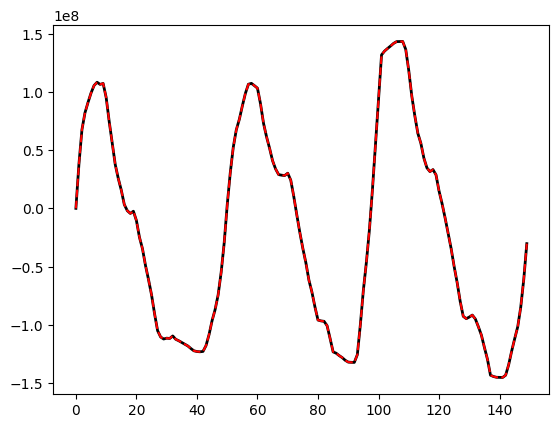

In [78]:
plt.plot(y_test[0,:,0],c='black',lw=2)
y_scaler = MinMaxScaler(y_train)
y_tmp = y_scaler.transform(y_test)
y_tmp = y_scaler.inverse_transform(y_tmp)
plt.plot(y_test[0,:,0],ls='--',c='red')

In [79]:
y_scaler = MinMaxScaler(y_train)
y_train = y_scaler.transform(y_train)
y_val = y_scaler.transform(y_val)
y_test = y_scaler.transform(y_test)

u_scaler = MinMaxScaler(u_train)
u_train = u_scaler.transform(u_train)
u_val = u_scaler.transform(u_val)
u_test = u_scaler.transform(u_test)

### Preprocess

In [80]:
def preprocess(y,u,k):
    assert y.shape[1] == u.shape[1]
    
    seq_len = u.shape[1]

    u_prev = torch.stack([u[:, i:i+k, 0] for i in range(seq_len-k)], axis=-1)
    u_prev = np.transpose(u_prev, (0, 2, 1))

    u_next = torch.stack([u[:, i+k, 0] for i in range(seq_len-k)], axis=-1)
    u_next = u_next.unsqueeze(-1)   

    y_prev = torch.stack([y[:, i:i+k, 0] for i in range(seq_len-k)], axis=-1)
    y_prev = np.transpose(y_prev, (0, 2, 1))

    y_next = torch.stack([y[:, i+k, 0] for i in range(seq_len-k)], axis=-1)
    y_next = y_next.unsqueeze(-1)

    input = torch.cat([y_prev,u_prev,u_next],axis=-1)
    output = y_next

    return input, output

In [81]:
k = 2

input_train, output_train = preprocess(y_train,u_train,k=k)
input_train.shape

torch.Size([140, 148, 5])

In [82]:
print(torch.cat([y_train[0,:k],u_train[0,:k+1]],axis=0).T,y_train[0,k])

tensor([[ 0.0135, -0.0613,  0.0013, -0.0553, -0.1307]]) tensor([-0.1610])


In [83]:
print(input_train[0,0], output_train[0,0])

tensor([ 0.0135, -0.0613,  0.0013, -0.0553, -0.1307]) tensor([-0.1610])


# Training

In [124]:
k,p,q = 8,8,3

model = MLP(2*k+1,1,p=p,q=q)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

input_train, output_train = preprocess(y_train,u_train,k=k)

In [125]:
num_epochs = 150

for epoch in range(num_epochs):
    for input, output_true in zip(input_train,output_train):
        output_pred = model(input)
        loss = loss_function(output_pred, output_true)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs} - Loss: {loss.item()}',end='\r')

In [126]:
def predict(y0,u):
    y_pred = y0
    for i in range(u.shape[1]-k):
        u_prev = u[:,i:i+k]
        u_next = u[:,i+k].unsqueeze(-1)
        y_prev = y_pred[:,i:i+k]
        input  = torch.cat([y_prev,u_prev,u_next],axis=-1)

        y_next = model(input)

        y_pred = torch.cat([y_pred,y_next],axis=-1)
    
    return y_pred

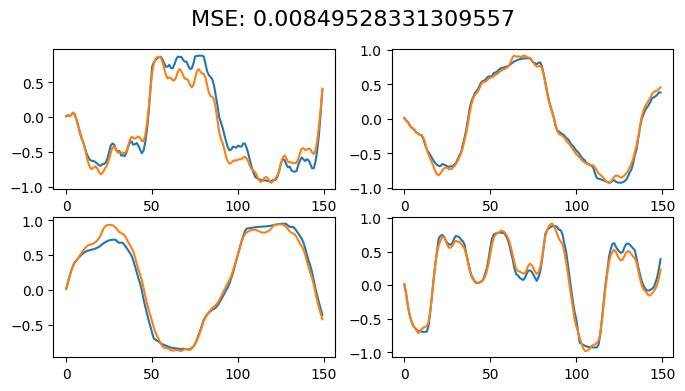

In [127]:
y0 = y_test[:,:k,0]
u = u_test[:,:,0]

y_pred = predict(y0,u)

error = ((y_test[:,:,0]-y_pred)**2).mean()

fig, ax = plt.subplots(2,2,figsize=(8,4))

ax[0,0].plot(y_test[20,:,0])
ax[0,0].plot(y_pred[20,:].detach().numpy())
ax[0,1].plot(y_test[21,:,0])
ax[0,1].plot(y_pred[21,:].detach().numpy())
ax[1,0].plot(y_test[22,:,0])
ax[1,0].plot(y_pred[22,:].detach().numpy())
ax[1,1].plot(y_test[24,:,0])
ax[1,1].plot(y_pred[24,:].detach().numpy())
plt.suptitle(f'MSE: {error}', fontsize=16)
plt.show()

# Data Loader version

In [69]:
from torch.utils.data import DataLoader, TensorDataset, random_split

y_list = torch.tensor(np.load("data/y_list.npy"),dtype=torch.float32).unsqueeze(-1)
u_list = torch.tensor(np.load("data/u_list.npy"),dtype=torch.float32).unsqueeze(-1)

y_train, y_tmp, u_train, u_tmp = train_test_split(y_list, u_list, test_size=0.3, random_state=42)
y_val, y_test, u_val, u_test = train_test_split(y_tmp, u_tmp, test_size=0.5, random_state=42)

y_scaler = MinMaxScaler(y_train)
y_train = y_scaler.transform(y_train)
y_val = y_scaler.transform(y_val)
y_test = y_scaler.transform(y_test)

u_scaler = MinMaxScaler(u_train)
u_train = u_scaler.transform(u_train)
u_val = u_scaler.transform(u_val)
u_test = u_scaler.transform(u_test)

input_train, output_train = preprocess(y_train,u_train,k=k)
input_val, output_val = preprocess(y_train,u_train,k=k)

train_loader = DataLoader(TensorDataset(input_train, output_train), batch_size=1, shuffle=False)
val_loader = DataLoader(TensorDataset(input_val, output_val), batch_size=1, shuffle=False)

In [70]:
model = MLP(2*k+1,1,p=p,q=q)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [71]:
num_epochs = 100

for epoch in range(num_epochs):
    
    model.train()

    for input, output_true in train_loader:
        optimizer.zero_grad()
        output_pred = model(input)
        loss = loss_function(output_pred,output_true)
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for input, output_true in val_loader:
            output_pred = model(input)
            val_loss += loss_function(output_pred,output_true)
    val_loss /= len(val_loader)

    print(f"\rEpoch {epoch+1}: Train Loss={loss.item():.4f}, Val Loss={val_loss:.4f}")

Epoch 1: Train Loss=0.2481, Val Loss=0.3596
Epoch 2: Train Loss=0.2189, Val Loss=0.3083
Epoch 3: Train Loss=0.1838, Val Loss=0.2523
Epoch 4: Train Loss=0.1471, Val Loss=0.1969
Epoch 5: Train Loss=0.1137, Val Loss=0.1468
Epoch 6: Train Loss=0.0871, Val Loss=0.1068
Epoch 7: Train Loss=0.0689, Val Loss=0.0787
Epoch 8: Train Loss=0.0581, Val Loss=0.0616
Epoch 9: Train Loss=0.0520, Val Loss=0.0520
Epoch 10: Train Loss=0.0476, Val Loss=0.0461
Epoch 11: Train Loss=0.0437, Val Loss=0.0417
Epoch 12: Train Loss=0.0396, Val Loss=0.0375
Epoch 13: Train Loss=0.0354, Val Loss=0.0333
Epoch 14: Train Loss=0.0308, Val Loss=0.0287
Epoch 15: Train Loss=0.0263, Val Loss=0.0242
Epoch 16: Train Loss=0.0218, Val Loss=0.0194
Epoch 17: Train Loss=0.0179, Val Loss=0.0152
Epoch 18: Train Loss=0.0149, Val Loss=0.0121
Epoch 19: Train Loss=0.0126, Val Loss=0.0097
Epoch 20: Train Loss=0.0111, Val Loss=0.0080
Epoch 21: Train Loss=0.0100, Val Loss=0.0070
Epoch 22: Train Loss=0.0093, Val Loss=0.0063
Epoch 23: Train Los

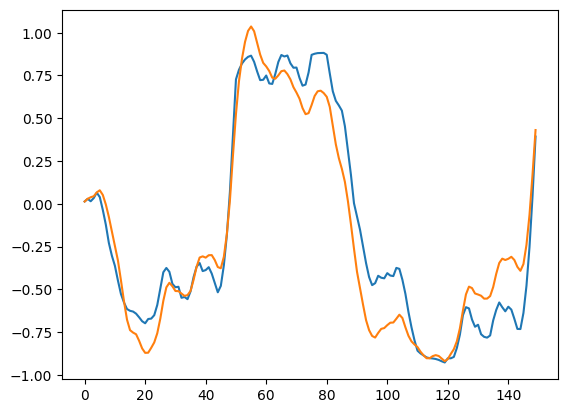

In [72]:
y0 = y_test[:,:k,0]
u = u_test[:,:,0]

y_pred = predict(y0,u)


plt.plot(y_test[20,:,0])
plt.plot(y_pred[20,:].detach().numpy())